## Week 8 Demo: Text
#### This demo is adapted from D7.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

# Import nltk package 
# NLTK provides support for a wide variety of text processing tasks: 
# tokenization, stemming, proper name identification, part of speech identification, etc. 
#   PennTreeBank word tokenizer 
#   English language stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# scikit-learn imports
#   TF-IDF Vectorizer that first removes widely used words in the dataset and then transforms test data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# import re for regular expression
import re

## seaborn for plotting
import seaborn as sns
sns.set(font_scale=1.2, style="white")

# import matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# improve resolution
%config InlineBackend.figure_format ='retina'

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('inaugural')

[nltk_data] Downloading package punkt to /Users/jasonc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jasonc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package inaugural to
[nltk_data]     /Users/jasonc/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

Now let's **import the `inaugural` dataset from `nltk.corpus`.**

In [3]:
from nltk.corpus import inaugural

You should be able to see all the txt files in the dataset, but here we just want to display the first 5 files:

In [4]:
inaugural.fileids()[0:5]

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt']

Let's then extract the years for each speech and save the years in a list called `years`.

In [5]:
years = []
for fileid in inaugural.fileids():
    years.append(fileid[:4])

Let's check if we have successfully extracted the years:

In [6]:
years[0:5]

['1789', '1793', '1797', '1801', '1805']

Let's take a look at one of the files:

In [7]:
# see Washington's Second Inaugural Address
inaugural.raw('1793-Washington.txt')

'Fellow citizens, I am again called upon by the voice of my country to execute the functions of its Chief Magistrate. When the occasion proper for it shall arrive, I shall endeavor to express the high sense I entertain of this distinguished honor, and of the confidence which has been reposed in me by the people of united America.\n\nPrevious to the execution of any official act of the President the Constitution requires an oath of office. This oath I am now about to take, and in your presence: That if it shall be found during my administration of the Government I have in any instance violated willingly or knowingly the injunctions thereof, I may (besides incurring constitutional punishment) be subject to the upbraidings of all who are now witnesses of the present solemn ceremony.\n\n \n'

You'll notice that there are some new line characters, as well as a colon, some commas, some periods. We're really only interested in the words though for TF-IDF, so let's remove all punctuation. **Write code that returns a list (`text`), where each element in the list includes the text as above, but with:
- punctuation removed 
- each word separated by a space
- all words are lower case (i.e. "Constitution" should be "constitution)

Here's a cheatsheet for regular expression: https://cheatography.com/davechild/cheat-sheets/regular-expressions/

#### Processing Inaugural Address Texts — Markdown Table

| **Step** | **Code Snippet** | **Explanation** |
|----------|------------------|-----------------|
| **1. Load Raw Texts** | `inaugural.raw(file_id)` | For each file ID in the NLTK inaugural corpus, retrieve the full raw text of the speech. |
| **2. List Comprehension** | `[inaugural.raw(file_id) for file_id in inaugural.fileids()]` | Iterates through all file IDs in the corpus to collect a list of raw speech texts. |
| **3. Clean Text** | `re.sub(r'[^A-Za-z0-9]+', ' ', x)` | Uses a regular expression to replace any non-alphanumeric characters (including punctuation) with spaces. |
| **4. Cleaned List Comprehension** | `[re.sub(r'[^A-Za-z0-9]+', ' ', x) for x in ...]` | Applies the cleaning function to each speech text to create a uniform, cleaned list of texts. |
| **5. Full Cleaning Pipeline** | `text = [re.sub(r'[^A-Za-z0-9]+', ' ', x) for x in [inaugural.raw(file_id) for file_id in inaugural.fileids()]]` | Combines the file reading and cleaning into one list comprehension to produce a cleaned list of inaugural addresses. |
| **6. Lowercase Conversion** | `map(str.lower, text)` | Applies the `lower()` function to each text to convert all characters to lowercase, making text processing case-insensitive. |
| **7. Convert to List** | `list(map(str.lower, text))` | Converts the map object into a list of lowercase texts. |
| **8. Final Assignment** | `text = list(map(str.lower, text))` | Stores the fully cleaned and normalized texts back in the `text` variable for further analysis. |

In [8]:
text = [re.sub(r'[^A-Za-z0-9]+', ' ', x) for x in [inaugural.raw(file_id) for file_id in inaugural.fileids()]]

text = list(map(str.lower, text))

Note: `re.sub(r'[\W]+', ' ', x)` or `re.sub(r'[^\w]+', ' ', x)` should also work in this case. The only difference is that these methods will also replace the underscore `'_'` with space.
- \w: word
- \W: non word

Now let's take a look at the cleaned data again:

In [10]:
# Print out the cleaned version of text data:
text[1]

'fellow citizens i am again called upon by the voice of my country to execute the functions of its chief magistrate when the occasion proper for it shall arrive i shall endeavor to express the high sense i entertain of this distinguished honor and of the confidence which has been reposed in me by the people of united america previous to the execution of any official act of the president the constitution requires an oath of office this oath i am now about to take and in your presence that if it shall be found during my administration of the government i have in any instance violated willingly or knowingly the injunctions thereof i may besides incurring constitutional punishment be subject to the upbraidings of all who are now witnesses of the present solemn ceremony '

Now, with the data cleaned, let's perform text analysis with TF-IDF!

#### What is TF-IDF?

**TF-IDF** stands for **Term Frequency–Inverse Document Frequency**. It is a numerical statistic that reflects how important a word is to a document in a collection (or corpus).

TF-IDF is commonly used in **text mining**, **information retrieval**, and **natural language processing** to convert textual data into meaningful numerical features.

#### Intuition

- **Term Frequency (TF)** measures how often a term appears in a document.
- **Inverse Document Frequency (IDF)** measures how unique or rare a term is across all documents.
- The idea is to **increase the weight** of terms that occur frequently in a document **but not in many other documents** (i.e., not too common).

#### Formula

Let:
- $ t $: a term (word)
- $ d $: a single document
- $ D $: the full corpus (set of documents)

#### Term Frequency (TF):
$
\text{TF}(t, d) = \frac{\text{Number of times } t \text{ appears in } d}{\text{Total number of terms in } d}
$

#### Inverse Document Frequency (IDF):
$
\text{IDF}(t, D) = \log\left(\frac{N}{1 + n_t}\right)
$
- $ N $: total number of documents in the corpus
- $ n_t $: number of documents where the term \( t \) appears
- (The `+1` avoids division by zero)

#### TF-IDF Score:
$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$

#### Why Use TF-IDF?

- Helps filter out **common words** (e.g., "the", "and", "is") that are less meaningful for distinguishing documents.
- Highlights **discriminative terms** that are more relevant or unique to individual documents.

---

#### Example Use Case

If the word *"freedom"* appears frequently in one president’s inaugural address but rarely in others, TF-IDF will assign it a **higher score** for that speech—indicating its importance in that context.

To get started on your TF-IDF analysis, you'll first want to **create a `TfidfVectorizer` object to transform your text data into vectors. Assign this `TfidfVectorizer` object to `tfidf`.**

In this object, you'll need to **pass five arguments to initialize a `TfidfVectorizer`**: 
* set to apply TF scaling: `sublinear_tf=True`
* analyze at the word-level: `analyzer='word'`
* set maximum number of unique words: ` max_features=2000`
* specify that you want to tokenize the data using the word_tokenizer from NLTK: `tokenizer=word_tokenize`
* remove English language stop words: `stop_words=stopwords.words("english")`

Note: Stop words are a set of commonly used words in a language,which are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so widely used that they carry very little useful information.

In [11]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=2000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

The `TfidfVectorizer` will transform raw text documents into a matrix where each row represents a document and each column represents one of the top 2000 words. The value in each cell is the TF-IDF score, which is a statistical measure used to evaluate the importance of a word to a document in a collection or corpus.

Now, it's time to calculate TF-IDF for words across our corpus of Inaugural addresses! 

To do this:

1. Use the `tfidf.fit_transform` function to calculate TF-IDF on your `text` variable. Use `.toarray()` to transform the output to a numpy array named `tfidf_array`. 
2. Generate a DataFrame `inaug_tfidf` by passing `tfidf_array` into `pd.DataFrame`.
2. Be sure that the columns are named with the columns of the words the values represent and your index in `inaug_tfidf` is the year of the address. The `get_feature_names` method from `tfidf` may help you accomplish the columns name assignment. And the `years` you created earlier may help you with the indices.

In [12]:
# Transform the preprocessed text data into a TF-IDF matrix and convert it to a pandas DataFrame.
# 1. tfidf.fit_transform(text): This line applies the previously initialized TfidfVectorizer to the text data.
#    - 'fit_transform' function computes the TF-IDF scores for each word in the text data.
#    - The result is a sparse matrix where each row corresponds to a document and each column represents 
# a term from the TF-IDF vocabulary.

inaug_tfidf = pd.DataFrame(tfidf.fit_transform(text).toarray())

# 2. Convert the sparse matrix to a dense matrix using '.toarray()', and then into a DataFrame.
#    - The DataFrame 'inaug_tfidf' represents the TF-IDF features of the text data, where each row is 
# a document and each column is a TF-IDF feature.

inaug_tfidf.columns = tfidf.get_feature_names_out()

# 3. Assign column names to the DataFrame using 'tfidf.get_feature_names_out()'.
#    - Each column in the DataFrame is named after a term in the TF-IDF vocabulary.

inaug_tfidf.index = years

# 4. Set the DataFrame index using 'years'.
#    - This implies that 'years' is an iterable (probably a list or array) that contains the years 
# associated with each text document.
#    - Each row in the DataFrame is now associated with a specific year, making it easier to reference 
# the documents chronologically.

Let's then take a look at the dataframe we just generated:

In [13]:
inaug_tfidf.head()

,000,abandon,abiding,ability,able,abroad,absolute,abundant,abuses,accept,...,write,written,wrong,year,years,yes,yet,yield,young,zeal
1789,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.025573,0.0,0.000000,0.0,0.0,0.000000
1793,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1797,0.0,0.000000,0.0,0.0,0.000000,0.033052,0.000000,0.0,0.043883,0.0,...,0.000000,0.000000,0.000000,0.050058,0.040654,0.0,0.000000,0.0,0.0,0.045530
1801,0.0,0.054265,0.0,0.0,0.000000,0.037863,0.052156,0.0,0.085115,0.0,...,0.054265,0.000000,0.062628,0.000000,0.000000,0.0,0.045462,0.0,0.0,0.052156
1805,0.0,0.000000,0.0,0.0,0.035451,0.000000,0.000000,0.0,0.072089,0.0,...,0.000000,0.039813,0.000000,0.048568,0.031823,0.0,0.038504,0.0,0.0,0.092705


Now, let's extract the single most unique word from each address and save it in a variable called `most_unique`

In [14]:
# Find the most uniquely significant word for each document in the TF-IDF matrix.
# 1. inaug_tfidf.idxmax(axis=1): This method is applied to the 'inaug_tfidf' DataFrame.
#    - 'idxmax' function finds the index (column name in this case) of the first occurrence 
# of the maximum value along the specified axis.
#    - 'axis=1' specifies that the operation is to be performed along the columns for each row.
#    - For each row (document) in the DataFrame, 'idxmax' identifies the column (word) that has 
# the highest TF-IDF score.
# 2. The result 'most_unique' is a pandas Series where the index corresponds to the indices of 
# documents in 'inaug_tfidf', 
#    and the values are the names of the words (columns in 'inaug_tfidf') that have the highest 
# TF-IDF score in each document.
#    - Essentially, this series maps each document to the word that is most uniquely significant 
# to that document based on TF-IDF scores.


most_unique = inaug_tfidf.idxmax(axis=1)

In [15]:
most_unique[:5]

1789    article
1793    thereof
1797     houses
1801    trusted
1805      false
dtype: object

Now let's plot the TF-IDF value for `"british"`, `"america"`, `"war"`, and `"jobs"` on the y-axis and plot the years on the x-axis.

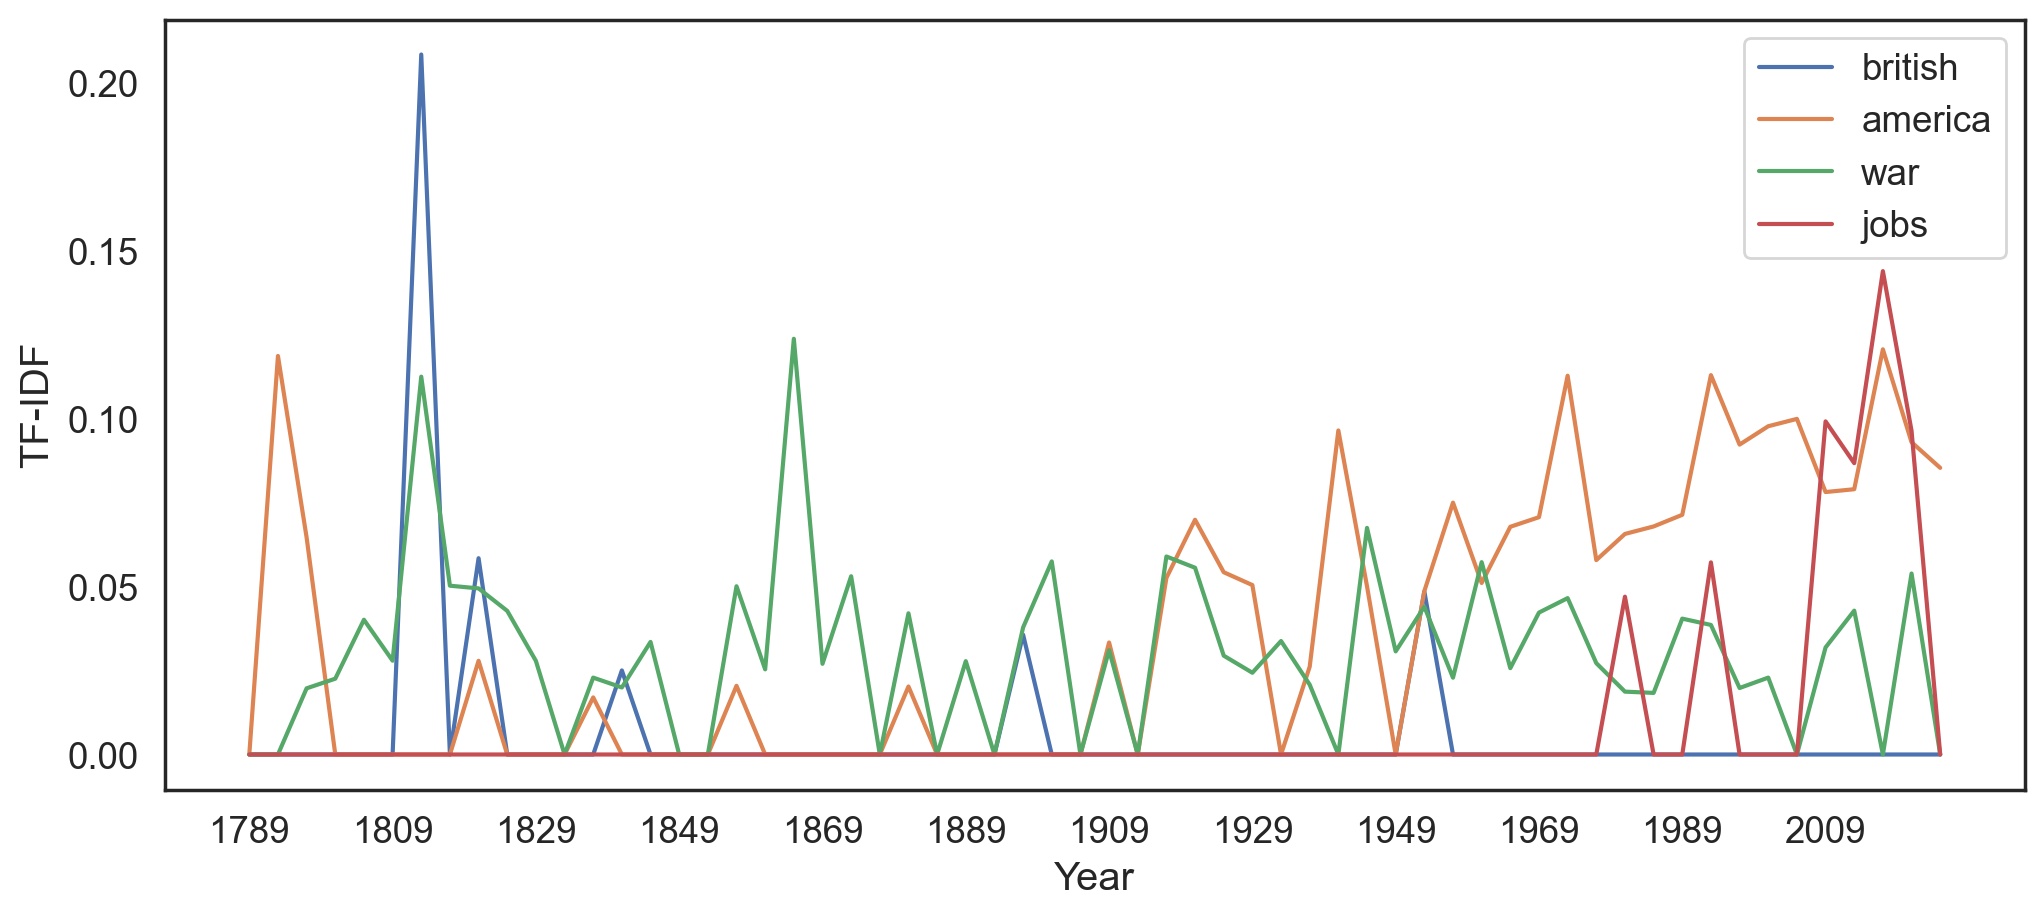

In [16]:
# Plotting TF-IDF scores for specific words across different years.
# 'x' is a list or array representing years corresponding to each document.
x = inaug_tfidf.index

plt.plot(x, inaug_tfidf['british'], label="british")
# Plot the TF-IDF scores of the word "british" across different years.

plt.plot(x, inaug_tfidf['america'], label="america")
# Plot the TF-IDF scores of the word "america" across different years.

plt.plot(x, inaug_tfidf['war'], label="war")
# Plot the TF-IDF scores of the word "war" across different years.

plt.plot(x, inaug_tfidf['jobs'], label="jobs")
# Plot the TF-IDF scores of the word "jobs" across different years.

# Setting the labels for the x and y axes.
plt.xlabel('Year')
plt.ylabel('TF-IDF')

# Adding a legend to the upper right corner of the plot.
plt.legend(loc="upper right")

# Setting the x-axis ticks. np.arange(0, 56, step=5) suggests the range starts at 0, 
# ends before 56, with a step of 5 for better visualization.
plt.xticks(np.arange(0, 56, step=5))

# Display the plot.
plt.show();

What kind of trend can you see from the plot?

Now you should be able to finish D7!